In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os 
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
import numpy as np
import json
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    LearningRateMonitor,
    EarlyStopping,
)

from scaler import FeaturesScaler
from dataloader import SimpleMagni
from simple_mlp import LightPointPredictor
from dataloader import PixWorldConverter

In [2]:
EXTRAS_PATH = "lhmp-thor-magni-challenge-extras" # set path to package directory 
DATA_PATH = os.path.join(EXTRAS_PATH, "data") # path to data directory 
MAPS_PATH = os.path.join(DATA_PATH, "maps") # path to obstacle maps and offsets.json


TRAIN_SCENARIOS = ["Scenario_1", "Scenario_2", "Scenario_3", "Scenario_4", "Scenario_5"]
TEST_SCENARIO = "Scenario_1"

In [3]:
train_scenarios = TRAIN_SCENARIOS
train_scenarios.remove(TEST_SCENARIO)
train_scenarios

['Scenario_2', 'Scenario_3', 'Scenario_4', 'Scenario_5']

In [4]:
HYPERPARAMETERS = {
    "lr" : 1e-3,
    "bs": 32,
    "scheduler_patience" : 5,
    "val_freq" : 2, # validation every n epochs
    "patience" : 10, # 10 epochs early stopping
}
DATA_CONFIG = {
    "inputs": ["speeds"],
    "obs_len" : 8,
    "pred_len" : 12, 
    "output": "speeds",
}

NETWORK_CONFIG = {
    "hidden_units": [32, 16],
    "dropout": 0.2,
    "batch_norm": True,
    "activation": "prelu",
    "obs_len" : DATA_CONFIG["obs_len"],
    "pred_len" : 12,
    "n_features" : 3,
    
}

# Loading data

In [5]:
train_tracklets = []
for train_scenario in train_scenarios:
    df = pd.read_csv(os.path.join(DATA_PATH, train_scenario + ".csv"), index_col = "Time")
    tracklets = [group for _, group in df.groupby("tracklet_id")]
    train_tracklets.extend(tracklets)

test_df = df = pd.read_csv(os.path.join(DATA_PATH, TEST_SCENARIO + ".csv"), index_col = "Time")
test_tracklets = [group for _, group in test_df.groupby("tracklet_id")]

In [6]:
len(train_tracklets), len(test_tracklets)

(5958, 2935)

# Scaler

In [7]:
full_ds_scl, statistics = FeaturesScaler.scale_dataset(train_tracklets)

# Dataloaders

In [8]:
train_ds = SimpleMagni(train_tracklets)
test_ds = SimpleMagni(test_tracklets)

In [9]:
train_dl = DataLoader(train_ds, HYPERPARAMETERS["bs"], shuffle=True)
test_dl = DataLoader(test_ds, HYPERPARAMETERS["bs"], shuffle=False)

# Model training

In [11]:
DATA_CONFIG.update(dict(training_data_stats=statistics))

In [12]:
model = LightPointPredictor(
    data_cfg=DATA_CONFIG,
    network_cfg=NETWORK_CONFIG,
    hyperparameters_cfg=HYPERPARAMETERS,
)

In [13]:
logger = TensorBoardLogger(os.path.join(EXTRAS_PATH, "logs"), name="simple_mlp", default_hp_metric=False)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", save_top_k=1, filename="{epoch}-{val_loss:.2f}"
)
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=HYPERPARAMETERS["patience"],
    verbose=False,
    mode="min",
)
lr_monitor = LearningRateMonitor(logging_interval="step")

In [14]:
trainer = pl.Trainer(logger=logger,
                     accelerator="cpu",
                     callbacks=[early_stop_callback, checkpoint_callback, lr_monitor],
                     default_root_dir=EXTRAS_PATH,
                     max_epochs=100,
                     check_val_every_n_epoch=HYPERPARAMETERS["val_freq"]
                     )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tmr/miniconda3/envs/tragen/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [15]:
trainer.fit(model, train_dl, test_dl)


  | Name  | Type      | Params
------------------------------------
0 | model | SimpleMLP | 1.8 K 
------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 40.19it/s]

/home/tmr/miniconda3/envs/tragen/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/tmr/miniconda3/envs/tragen/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 65: 100%|██████████| 187/187 [00:11<00:00, 16.27it/s, v_num=2, train_loss_step=0.966, train_loss_epoch=1.070, val_loss=0.885]


In [16]:
trainer.test(ckpt_path = "best", dataloaders = test_dl)

Restoring states from the checkpoint path at lhmp-thor-magni-challenge-extras/logs/simple_mlp/version_2/checkpoints/epoch=57-val_loss=0.84.ckpt
Loaded model weights from the checkpoint at lhmp-thor-magni-challenge-extras/logs/simple_mlp/version_2/checkpoints/epoch=57-val_loss=0.84.ckpt
/home/tmr/miniconda3/envs/tragen/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

Testing DataLoader 0: 100%|██████████| 92/92 [00:03<00:00, 23.28it/s]


[{}]

# Inference 
(You need to set the **CHECKPT_PATH**)

In [17]:
TEST_BATCH_IDX = 0
TEST_SAMPLE_IDX = 2
CHECKPT_PATH = f"{EXTRAS_PATH}/logs/simple_mlp/version_0/checkpoints/epoch=35-val_loss=0.85.ckpt" # set path to a checkpoint

In [18]:
model_pred = LightPointPredictor.load_from_checkpoint(
    CHECKPT_PATH,
    data_cfg=DATA_CONFIG,
    network_cfg=NETWORK_CONFIG,
    hyperparameters_cfg=HYPERPARAMETERS,
    map_location={"cuda:0": "cpu"},
)

In [19]:
model_pred.eval()
out_samples = {"gt": [], "y_hat": []}
for batch_idx, batch in enumerate(test_dl):
    yhat = model_pred.predict_step(batch, batch_idx)
    out_samples["gt"].append(yhat["gt"])
    out_samples["y_hat"].append(yhat["y_hat"])

In [20]:
gt_batch, pred_batch = out_samples["gt"][TEST_BATCH_IDX],out_samples["y_hat"][TEST_BATCH_IDX][0]

In [21]:
if MAPS_PATH:
    with open(os.path.join(MAPS_PATH, "offsets.json"), "rb") as f:
        offsets = json.load(f)
    pix2word_converters = dict(
        May=PixWorldConverter(dict(resolution_pm=0.01, offset=offsets["May"])),
        September=PixWorldConverter(dict(resolution_pm=0.01, offset=offsets["September"])),
)

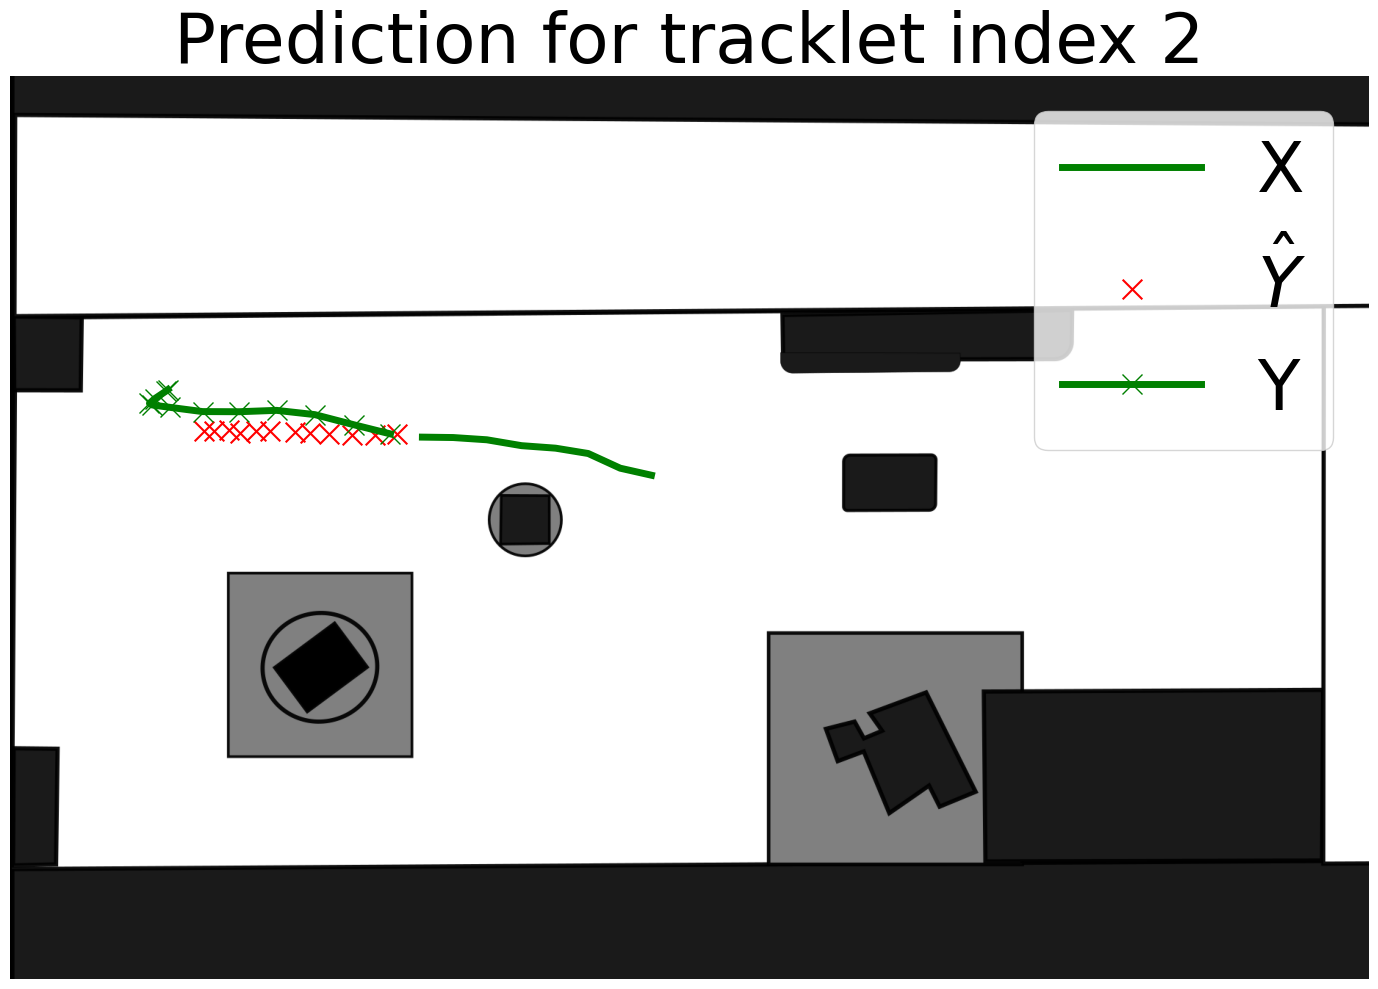

In [23]:
plt.figure(figsize=(20, 10))
plt.title(f"Prediction for tracklet index {TEST_SAMPLE_IDX}", fontsize=50)


observations_plt = gt_batch[TEST_SAMPLE_IDX][DATA_CONFIG["obs_len"]:, :]
predictions_plt = pred_batch[TEST_SAMPLE_IDX]
ground_truth_plt = gt_batch[TEST_SAMPLE_IDX][:DATA_CONFIG["obs_len"], :]

if MAPS_PATH:
    map_name = test_tracklets[TEST_SAMPLE_IDX]["map_name"].iloc[0]
    img = np.array(Image.open(os.path.join(MAPS_PATH, map_name)))
    spatial_layout = np.flipud(img[:, :, :3])
    plt.imshow(spatial_layout)
    month = "September" if map_name.startswith("3009") else "May"
    observations_plt = pix2word_converters[month].convert2pixels(observations_plt[:, :2])
    predictions_plt = pix2word_converters[month].convert2pixels(predictions_plt)
    ground_truth_plt = pix2word_converters[month].convert2pixels(ground_truth_plt[:, :2])
    

plt.plot(
    ground_truth_plt[:, 0],
    ground_truth_plt[:, 1],
    color="green",
    label = "X",
    linewidth=5,
)
plt.scatter(
    predictions_plt[:, 0],
    predictions_plt[:, 1],
    color="red",
    marker="x", 
    label = r"$\hat{Y}$",
    s=200,
)
plt.plot(
    observations_plt[:, 0],
    observations_plt[:, 1],
    color="green",
    marker="x", 
    label = r"Y",
    linewidth=5,
    markersize=15,
)
plt.legend(fontsize=50);
plt.axis("off")
plt.xlim([0, 1850])
plt.ylim([500, 1730])
plt.tight_layout()